# Stochastic Simulation of Newsvendor Problem

In [22]:
#Author: Matias Kühnau 

The interest of this project is to examine how the data driven newsvendor problem can be solved in the aspect of energy markets. 
Energy markets are forecast dependant when renewable energy producers enter the market, as the forecasts will determine the bids of renewable producers. 
When a renewable producer bids into the market, they shift the production curve of the aggregated producers, due to them having zero marginal cost. 

In the first instance, we are interested in simulating how the penalty distribution lies based on a random distribution (here beta). 
I.e. how do we minimize penalty given some penalty cost for overproduction and underproduction, and a realization of power drawn randomly?


In [1]:
#Initialization
using Plots
using GLPK
using Printf
using JuMP 
using Gurobi 
gurobi_env = Gurobi.Env()
using Random, Distributions
using PrettyTables
    Random.seed!(13245)
N  = 10000


Academic license - for non-commercial use only


10000

The penalties and variables are called: 

In [2]:
cplus = 12
cminus = 7
meanvec1 = zeros(0)
meanvec2 = zeros(0)
meanvec3 = zeros(0)
ebcountvec = zeros(0)
eb = 0 
Betadist1 = Beta(2,4)
Betadist2 = Beta(4,2)
Betadist3 = Beta(1,1)

Beta{Float64}(α=1.0, β=1.0)

Now we will try to bid. Assuming that everything is normalized, we have an initial bid of, for example eb = 0.01. The penalties can be calculated as: 
\begin{align}
    P^+ = E_t[\omega_t-x_{t})\cdot \pi^+] \quad \forall \omega_{t} > x_{t} \\
    P^- = E_t[(x_{t}-\omega_t)\cdot \pi^-] \quad \forall \omega_{t} < x_{t} 
\end{align}

In [3]:
ebsingle = 0+eb
#The beta sample gives a realization of what we actually get: 
ep = rand(Betadist1,1)
println("The realisation is: ",ep)
#If ep>eb we pay penalty (ep-eb)*cplus if ep<eb we pay penalty (eb-ep)*cminus
#We can run this a couple of times and see what the penalties become: 
pvec = zeros(0)
if (ep[1] > ebsingle)
    penalty = (ep[1]-ebsingle)*cplus
elseif(ebsingle > ep[1])
    penalty = (ebsingle-ep[1])*cminus
elseif(ebsingle == ep[1]) #Extremely unlikely
    penalty = 0 
end
pvec = append!(pvec,penalty)
println("The penalty is:", sort(pvec))


The realisation is: [0.16594069949852253]
The penalty is:[1.9912883939822703]


Now we have an intuitive understanding of what happens in every "realization" of the market. Now we can begin to examine how we consistently minimize the penalty based on our bid. 
This can be looked at in two different ways: 
 - Stochastically 
 - Linear Programming
 
To begin with we will examine a stochastic approach to this. 
 

## Stochastic approach

Lets try to vary the bid across 100 different values from 0.01 to 1. 
For each bid, we will simulate 1000 realisations of the production and calculate the penalty. 
Using the expectation of each bid, we can calculate what we expect to lose dependant on the bid. 

In [4]:
pricevec1 = zeros(N)
pricevec2 = zeros(N)
pricevec3 = zeros(N)
meanvec1 = zeros(0)
meanvec2 = zeros(0)
meanvec3 = zeros(0)
ebcountvec = zeros(0)
for i in 1:100
    eb = eb + 0.01
    ep1 = rand(Betadist1,N)
    ep2 = rand(Betadist2,N)
    ep3 = rand(Betadist3,N)
    #Vector of bids 
    ebvec = repeat([eb],N)
      #First distribution
      mask1low = findall(ep1.<ebvec)
      mask1hi  = findall(ep1.>=ebvec)
      pricevec1[mask1hi] = (ep1[mask1hi]-ebvec[mask1hi])*cplus
      pricevec1[mask1low] = (ebvec[mask1low]-ep1[mask1low])*cminus
      meanvec1 = append!(meanvec1,mean(pricevec1))
      #Second distribution
      mask2low = findall(ep2.<ebvec)
      mask2hi  = findall(ep2.>=ebvec)
      pricevec2[mask2hi] = (ep2[mask2hi]-ebvec[mask2hi])*cplus
      pricevec2[mask2low] = (ebvec[mask2low]-ep2[mask2low])*cminus
      meanvec2 = append!(meanvec2,mean(pricevec2))
      #Third   distribution
      mask3low = findall(ep3.<ebvec)
      mask3hi  = findall(ep3.>=ebvec)
      pricevec3[mask3hi] = (ep3[mask3hi]-ebvec[mask3hi])*cplus
      pricevec3[mask3low] = (ebvec[mask3low]-ep1[mask3low])*cminus
      meanvec3 = append!(meanvec3,mean(pricevec3))
      #Counter
      ebcountvec = append!(ebcountvec,eb)
end
eb = 0
println("Minimum of distribution 1: ",minimum(meanvec1))
println("Minimum of distribution 2: ",minimum(meanvec2))
println("Minimum of distribution 3: ",minimum(meanvec3))
println("Finished")

Minimum of distribution 1: 1.3396329206321496
Minimum of distribution 2: 1.2475602037880549
Minimum of distribution 3: 2.028856422653127
Finished


Now let us vizualise these results

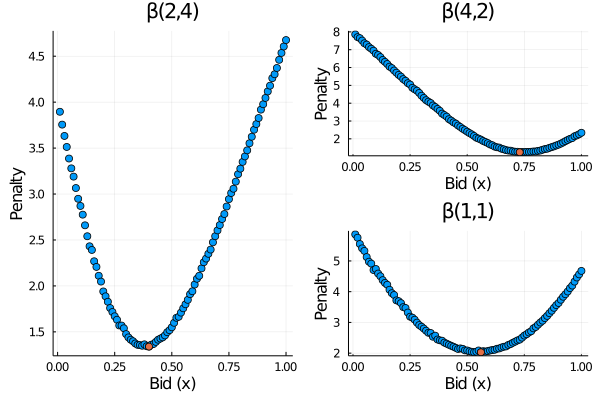

In [5]:
a = scatter(ebcountvec,meanvec1)
adot = scatter!((ebcountvec[argmin(meanvec1)],minimum(meanvec1)), title = "β(2,4)", legend = false, ylab = "Penalty", xlab = "Bid (x)")
suba = plot(a,adot)
b = scatter(ebcountvec,meanvec2)
bdot = scatter!((ebcountvec[argmin(meanvec2)],minimum(meanvec2)),title = "β(4,2)", legend = false, ylab = "Penalty", xlab = "Bid (x)")
subb = plot(b,bdot)
c = scatter(ebcountvec,meanvec3)
cdot = scatter!((ebcountvec[argmin(meanvec3)],minimum(meanvec3)),title = "β(1,1)", legend = false, ylab = "Penalty", xlab = "Bid (x)")

subc = plot(c,cdot)
l = @layout [
    a{0.5w} [c{0.5h}
             b{0.5h}  ]
]
plot(adot,bdot,cdot,layout = l)
#savefig("C:\\Users\\matia\\StochasticNewsvendor\\PenaltyDist1.png")

┌ Info: Saved animation to 
│   fn = C:\Users\matia\StochasticNewsvendor\tutorial_anim_fps30.gif
└ @ Plots C:\Users\matia\.julia\packages\Plots\GDtiZ\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\matia\\StochasticNewsvendor\\tutorial_anim_fps30.gif")
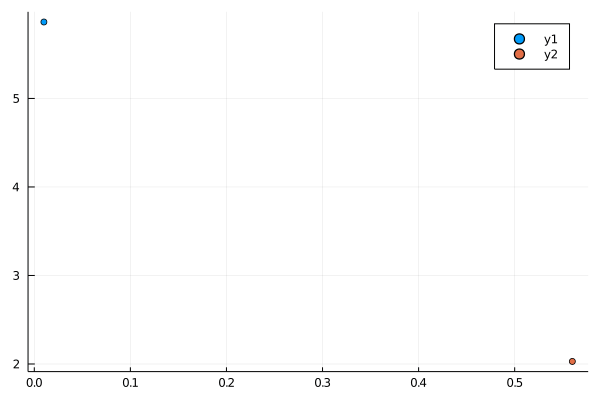

In [6]:
anim = @animate for i = 1:100
    scatter(ebcountvec[1:i],meanvec3[1:i])
    scatter!((ebcountvec[argmin(meanvec3)],minimum(meanvec3)))
end
 
gif(anim, "tutorial_anim_fps30.gif", fps = 10)

As we can see, dependant on the distribution, the optimal bid changes, but for each distribution there is a clear minima observed. This is then the optimal bidding strategy based on the distribution and the given penalties. 

# Solving the problem as an LP 

The alternative to solving the problem in a stochastic manner as shown before, is to formulate the stochastic newsvendor problem as a linear programming problem, that can then be solved in julia. 

$$
\begin{align} \label{eq:slp-newsvendor}
\min_{x} && c x + \mathbb{E} \left[ Q(x, \omega) \right] \\
&& Q(x,\omega) & = \min_{y_1,y_2,y_3} & - (c+\delta) y_1 -\eta y_3 \nonumber \\
&&             & \qquad \text{s.t.}          & y_1 + y_2 = \omega \nonumber \\
&&             &                      & y_1 + y_3 = x \nonumber \\
&&             &                      & x,y_1,y_2,y_3 \geq 0 \nonumber
\end{align}
$$


### Explanation of the stochastic program constraints (AKA how to avoid big M constraints). 

The problem with the given 

In [20]:
#Draw variable from the beta distribution. 
#Choose a distribution here: 
#y = rand(Betadist1,N)
#y = rand(Betadist2,N)
y = rand(Betadist3,N)
#Production curve variables
piplus = 12
piminus =7

#Day ahead price is seen as a fraction of balancing prices: 
c = piplus/(piplus+piminus)

m = Model(with_optimizer(GLPK.Optimizer))

@variable(m, x>=0) #Bid variable, (here and now decision)
@variable(m, z1[1:N]>=0) # Recourse variable (if we are under bid)
@variable(m, z2[1:N]>=0) # Recourse variable (should basically equate to x)
@variable(m, z3[1:N]>=0) # Recourse variable (if we are over bid)
@constraint(m,[i=1:N],z1[i]+z3[i]==y[i]) #Ensure that power production is fullfilled
@constraint(m,[i=1:N],-x+z1[i]+z2[i] == 0)
@objective(m, Min, (-c)*x + (1/N)*sum( ((c+piplus)*z2[i])-(c-piminus)*z3[i] for i = 1:N))# We want to minimize penalty
JuMP.optimize!(m)
if termination_status(m) == MOI.OPTIMAL
    println("The value is: $(objective_value(m))")
    println("The bids are: $(JuMP.value.(x))")
    println("The expectation is:", JuMP.value.(x))
    yc = JuMP.value.(x)
    obj_pricetaker = JuMP.objective_value(m)
else
    println("No optimal solution available")
end

The value is: 1.8854272477232268
The bids are: 0.3696526672086381
The expectation is:0.3696526672086381


1.8854272477232268

The model bids around 0.36 dependant on the realizations. The objective value looks close to what the realization of the minima becomes in the stochastic simulation approach. We could also try to calculate an analytical solution to the problem.

# Price Taker Assumption

Implementing the basic model was seen as rather simple. We now wish to expand upon the base assumption that the bidder has no impact on the clearing price. With this in mind, lets see what happens if we take the calculated x value, and allow the model to change the increment value slightly (x+$\lambda$) Where $\lambda$ is scenario specific balancing and $x$ is a constant. We introduce 𝛼, 𝛽 as:

$$
\begin{align}
\alpha_t^+ &= \pi^++\beta^+\lambda_t \\
\alpha_t^- &= \pi^-+\beta^-\lambda_t \\
\end{align}
$$


Lets begin by attempting to formulate the stochastic simulation, then define the problem as an integral, and then calculate if there is an analytical solution by finding the derivative. 

We have the new penalties as: 
\begin{align}
    P^+ = \mathbb{E}_t[\omega_t-x+\lambda_t)\cdot \alpha_t^+] \quad \forall \lambda_{t} > x \\
    P^- = \mathbb{E}_t[(x+\lambda_t-\omega_t)\cdot \alpha_t^-] \quad \forall \lambda_{t} < x 
\end{align}

The new problem is formulated as: 
$$
\begin{align}
&\mathbb{E}[I(e_p,e_b,\lambda,p_s,\alpha^+,\alpha^-)]\\
&= \int_{-x}^{\lambda}((e_b+\lambda-e_p)\cdot \alpha^-\cdot f(e_p))de_p + \int_{\lambda}^{(m_p-x)}((e_p-e_b+\lambda)\cdot \alpha^+\cdot f(e_p))de_p
\end{align}
$$

While it is not possible to find an analytical minima to this formulation, we can once again use stochastic simulation to estimate a minima and visualize how the model works: 

In [8]:
#Now we have: 
newpricevec1 = zeros(N)
newpricevec2 = zeros(N)
newpricevec3 = zeros(N)
newmeanvec1 = zeros(0)
newmeanvec2 = zeros(0)
newmeanvec3 = zeros(0)
newbidcountvec = zeros(0)
#Introduce the new price variable beta
betaplus = 0.06
betaminus = 0.04

#We are no longer bidding, we are now changing the bid slightly: 
bid = repeat([yc],N) #Original bid
piplusvec = repeat([piplus],N)
piminusvec = repeat([piminus],N)
#Vector of bid change increments
lambda = [-yc:0.01:(1-yc);]

#Say we want to test for average across all lambda values 
for i in 1:length(lambda)
    #Calculate penalty for bid: 
    ep1 = rand(Betadist1,N)
    ep2 = rand(Betadist2,N)
    ep3 = rand(Betadist3,N)
    #First distribution
    val = (bid .+ lambda[i])
    mask1low = findall(ep1.<val)
    mask1hi  = findall(ep1.>=val)
    #First find penalty for original bid across all realizations:
    newpricevec1[mask1hi] = (ep1[mask1hi].-(bid[mask1hi].+lambda[i])).*(piplusvec[mask1hi].+betaplus*lambda[i])
    newpricevec1[mask1low] = ((lambda[i].+bid[mask1low])-ep1[mask1low]).*(piminusvec[mask1low].+betaminus*lambda[i])
    newmeanvec1 = append!(newmeanvec1,mean(newpricevec1))
    #Second distribution
    mask2low = findall(ep2.<val)
    mask2hi  = findall(ep2.>=val)
    newpricevec2[mask2hi] = (ep2[mask2hi]-(bid[mask2hi].+lambda[i])).*(piplusvec[mask2hi].+betaplus*lambda[i])
    newpricevec2[mask2low] = ((lambda[i].+bid[mask2low])-ep2[mask2low]).*(piminusvec[mask2low].+betaminus*lambda[i])
    newmeanvec2 = append!(newmeanvec2,mean(newpricevec2))
    #Third distribution: 
    mask3low = findall(ep3.<val)
    mask3hi  = findall(ep3.>=val)
    newpricevec3[mask3hi] = (ep3[mask3hi]-(bid[mask3hi].+lambda[i])).*(piplusvec[mask3hi].+betaplus*lambda[i])
    newpricevec3[mask3low] = ((lambda[i].+bid[mask3low])-ep3[mask3low]).*(piminusvec[mask3low].+betaminus*lambda[i])
    newmeanvec3 = append!(newmeanvec3,mean(newpricevec3))
end
lambda


eb = 0
println("Minimum of distribution 1: ", minimum(newmeanvec1))
println("Length: ", length(newmeanvec1))
println("Corresponding to a λ value of: ", lambda[findmin(newmeanvec1)[2]])
println("Minimum of distribution 2: ", minimum(newmeanvec2))
println("Length: ", length(newmeanvec2))
println("Corresponding to a λ value of: ", lambda[findmin(newmeanvec2)[2]])
println("Minimum of distribution 3: ", minimum(newmeanvec3))
println("Length: ", length(newmeanvec3))
println("Corresponding to a λ value of: ", lambda[findmin(newmeanvec3)[2]])
#println("Minimum of distribution 2: ",minimum(meanvec2))
#println("Minimum of distribution 3: ",minimum(meanvec3))
println("Finished")

Minimum of distribution 1: 1.327733150554985
Length: 101
Corresponding to a λ value of: 0.027915704064489455
Minimum of distribution 2: 1.2483658010499852
Length: 101
Corresponding to a λ value of: 0.39791570406448945
Minimum of distribution 3: 2.1827975101548045
Length: 101
Corresponding to a λ value of: 0.24791570406448943
Finished


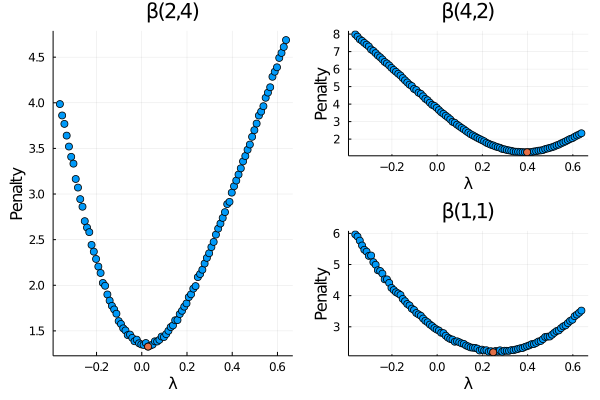

In [9]:
a = scatter(lambda,newmeanvec1,xlabel ="λ", ylabel = "Penalty")
adot = scatter!((lambda[argmin(newmeanvec1)],minimum(newmeanvec1)),title = "β(2,4)",legend = false)
suba = plot(a,adot)
b = scatter(lambda,newmeanvec2,xlabel ="λ", ylabel = "Penalty")
bdot = scatter!((lambda[argmin(newmeanvec2)],minimum(newmeanvec2)),title = "β(4,2)",legend = false)
subb = plot(b,bdot)
c = scatter(lambda,newmeanvec3,xlabel ="λ", ylabel = "Penalty")
cdot = scatter!((lambda[argmin(newmeanvec3)],minimum(newmeanvec3)),title = "β(1,1)",legend = false)
subc = plot(c,cdot)

l = @layout [
    a{0.5w} [c{0.5h}
             b{0.5h}  ]
]
plot(adot,bdot,cdot,layout = l)
#savefig("C:\\Users\\matia\\StochasticNewsvendor\\PenaltyDist2.png")

It is clearly observed that there seems to be an optimal nonzero value of $\lambda$ when the bidder has the oppertunity to change the bid slightly after setting the balancing price! 
This confirms that the original model may benefit from moving away from the price taker assumption completely, and instead attempt to create a model that can account for this and benefit from the added complexity. 

 Lets see how this compares to trying to solve the problem as an optimization problem: 


In [10]:
#=

#New model with incremental change
increm = Model(with_optimizer(Gurobi.Optimizer))
set_optimizer_attribute(increm, "NonConvex", 2)

#increm.Params.NonConvex = 2
alphaplus = 0.5 #piplus/(piplus+piminus)
alphaminus  = 0.4  # piminus/(piplus+piminus)
𝛽 = c
println("Here")

@variable(increm, lambda) #Increment value, should be free, (here and now decision)
@variable(increm, z1[1:N]>=0) # Recourse variable (should basically equate to x)
@variable(increm, z2[1:N]>=0) # Recourse variable (if we are under bid)
@variable(increm, z3[1:N]>=0) # Recourse variable (if we are over bid)
#
#We need new constraints to reflect that we are changing the increment values 
#Need to somehow reflect scenario dependant 
@constraint(increm,[i=1:N],z1[i]+z3[i]==y[i])
@constraint(increm,[i=1:N],-(yc+lambda)+z1[i]+z2[i] == 0)
@objective(increm, Min, (-c)*(lambda+yc) + (1/N)*sum( (c+(lambda*alphaplus+piplus))*(z3[i])
        - (c-(alphaminus*lambda+piminus))*(z2[i]) for i = 1:N))# We want to minimize penalty

JuMP.optimize!(increm)
if termination_status(increm) == MOI.OPTIMAL
    println("The value is: $(objective_value(m))")
    println("The increment value is:", JuMP.value.(lambda))
else
    println("No optimal solution available")
end
=#

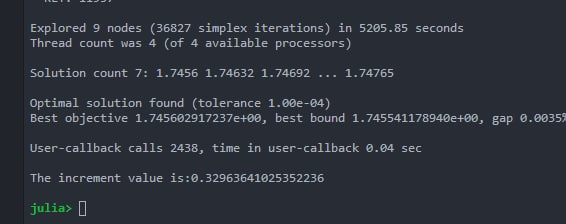

The problem becomes nonconvex and very hard to run. After a significant time investment (about 1.5 hours) and implementing the problem on a gurobi solver the problem is solved. The objective does change quite significally from the previous solution, but the lambda value is also quite big when considering that it is added on top of the previous x value. This further confirms that being a price setter brings with it a significant possibility for further optimization of the penalties.

# Implementing the program as Price Maker

Now we are interested to see how the behaviour will change when we aggregate more players into the market.
I.e. we know that the bids are aggregated across different market and can be represented as a function. In practice, this means that our slope becomes a function on its own, dependant on the distribution and the bid: 
$$ 
\alpha_t^+ = \pi_0^++\beta^+(\omega_t-x_{t}) \; \; \forall x_t \geq \omega_t \\
\alpha_t^-= \pi_0^-+\beta^-(x_{t}-\omega_t) \; \; \forall x_t \leq \omega_t  
$$
    

The penalties would thus be: 
\begin{align}
    P^+ = \mathbb{E}_t[(\omega_t-x_t)\cdot \alpha_t^+] \quad \forall \omega_{t} > x_t \\
    P^- = \mathbb{E}_t[(x_t-\omega_t)\cdot \alpha_t^-] \quad \forall \omega_{t} < x_t
\end{align}

Our new representation would thus become: 
$$
\mathbb{E}[\pi_0^+,\pi_0^-,\beta^+,\beta^+,f(\omega),x_t ] = 
\begin{align}
&\int_0^x(\pi_0^++\beta^+(\omega-x)(\omega-x))f(\omega)\partial \omega + \int_x^1((\pi_0^-+\beta^-(x-\omega)(x-\omega))f(\omega)\partial \omega \\
\end{align}
$$




Once again we attempt to formulate an analytical solution, but it is seen as impossible to find an analyical solution due to the quadratic terms.
Instead we will once again use stochastic simulation to approximate a minimal value accross the different distributions:

In [11]:
#Now we have: 
newpricevec1 = zeros(N)
newpricevec2 = zeros(N)
newpricevec3 = zeros(N)
newmeanvec1 = zeros(0)
newmeanvec2 = zeros(0)
newmeanvec3 = zeros(0)
newbidcountvec = zeros(0)
#Introduce the new price variable beta
betaplus = 0.5
betaminus = 0.4

#We are no longer bidding, we are now changing the bid slightly: 
bid = repeat([yc],N) #Original bid
piplusvec = repeat([piplus],N)
piminusvec = repeat([piminus],N)
#Vector of bid change increments
x = [0:0.01:1;]

#Test N times for all bid values
for i in 1:length(x)
    #Calculate penalty for bid: 
    ep1 = rand(Betadist1,N)
    ep2 = rand(Betadist2,N)
    ep3 = rand(Betadist3,N)
    bidvec = repeat([x[i]],N)
    #First distribution
    mask1low = findall(ep1.<bidvec)
    mask1hi  = findall(ep1.>=bidvec)
    #First find penalty for original bid across all realizations:
    newpricevec1[mask1hi] = (ep1[mask1hi].-bidvec[mask1hi]).*(piplusvec[mask1hi].+betaplus*bidvec[mask1hi])
    newpricevec1[mask1low] = (bidvec[mask1low].-ep1[mask1low]).*(piminusvec[mask1low].+betaminus*bidvec[mask1low])
    newmeanvec1 = append!(newmeanvec1,mean(newpricevec1))
    #Second distribution
    mask2low = findall(ep2.<bidvec)
    mask2hi  = findall(ep2.>=bidvec)
    newpricevec2[mask2hi]  = (ep2[mask2hi]-bidvec[mask2hi]).*(piplusvec[mask2hi].+betaplus*bidvec[mask2hi])
    newpricevec2[mask2low] = (bidvec[mask2low]-ep2[mask2low]).*(piminusvec[mask2low].+betaminus*bidvec[mask2low])
    newmeanvec2 = append!(newmeanvec2,mean(newpricevec2))
    #Third distribution: 
    mask3low = findall(ep3.<bidvec)
    mask3hi  = findall(ep3.>=bidvec)
    newpricevec3[mask3hi] = (ep3[mask3hi].-bidvec[mask3hi]).*(piplusvec[mask3hi].+betaplus*bidvec[mask3hi])
    newpricevec3[mask3low] = (bidvec[mask3low].-ep3[mask3low]).*(piminusvec[mask3low].+betaminus*bidvec[mask3low])
    newmeanvec3 = append!(newmeanvec3,mean(newpricevec3))
end
lambda


eb = 0
println("Minimum of distribution 1: ", minimum(newmeanvec1))
println("Length: ", length(newmeanvec1))
println("Corresponding to a bid value of: ", x[findmin(newmeanvec1)[2]])
println("Minimum of distribution 2: ", minimum(newmeanvec2))
println("Length: ", length(newmeanvec2))
println("Corresponding to a bid value of: ", x[findmin(newmeanvec2)[2]])
println("Minimum of distribution 3: ", minimum(newmeanvec3))
println("Length: ", length(newmeanvec3))
println("Corresponding to a bid value of: ", x[findmin(newmeanvec3)[2]])
#println("Minimum of distribution 2: ",minimum(meanvec2))
#println("Minimum of distribution 3: ",minimum(meanvec3))
println("Finished")

Minimum of distribution 1: 1.3646241667913135
Length: 101
Corresponding to a bid value of: 0.39
Minimum of distribution 2: 1.3006295392149514
Length: 101
Corresponding to a bid value of: 0.73
Minimum of distribution 3: 2.2713734096889784
Length: 101
Corresponding to a bid value of: 0.63
Finished


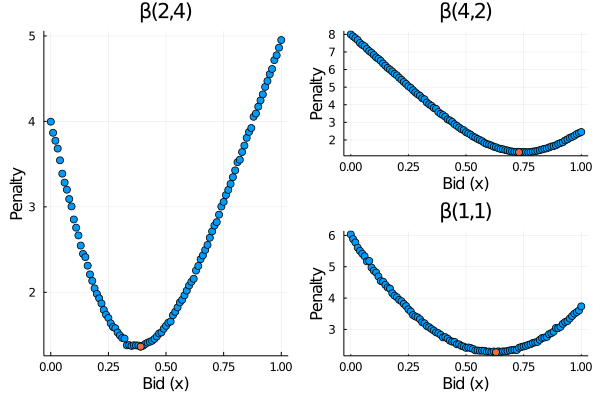

In [12]:
a = scatter(x,newmeanvec1,xlabel ="Bid (x)", ylabel = "Penalty")
adot = scatter!((x[argmin(newmeanvec1)],minimum(newmeanvec1)),title = "β(2,4)",legend = false)
suba = plot(a,adot)
b = scatter(x,newmeanvec2,xlabel ="Bid (x)", ylabel = "Penalty")
bdot = scatter!((x[argmin(newmeanvec2)],minimum(newmeanvec2)),title = "β(4,2)",legend = false)
subb = plot(b,bdot)
c = scatter(x,newmeanvec3,xlabel ="Bid (x)", ylabel = "Penalty")
cdot = scatter!((x[argmin(newmeanvec3)],minimum(newmeanvec3)),title = "β(1,1)",legend = false)
subc = plot(c,cdot)

l = @layout [
    a{0.5w} [c{0.5h}
             b{0.5h}  ]
]
plot(adot,bdot,cdot,layout = l)
#savefig("C:\\Users\\matia\\StochasticNewsvendor\\PenaltyDist3.png")

It doesn't seem to be a big problem to run the problem stochastically. And further a clear minima is seen. Obviously this problem might be subject to quite large change if the form of the function we use to approximate our bids impact on the market changes. 
Lets see if we cant implement this as a SQP (stochastic quadratic program). 

## Stochastic Program Solution 

After seeing that stochastic simulation is a possibility for solving the problem, but that the analytical solution seems infeasible to derive, we will attempt to create a new stochastic program that can handle the new quadratic objective function: 

In [13]:
#Production curve variables
piplus = 12
piminus = 7

#We need to figure out this exact relation. 
c = piplus/(piplus+piminus)
#Note that we call these beta values in the report(!)
alphaplus = 0.5
alphaminus = 0.4

m = Model(with_optimizer(Gurobi.Optimizer,gurobi_env))

@variable(m, u>=0) #Bid variable, (here and now decision)
@variable(m, z1[1:N]>=0) # Recourse variable (if we are under bid)
@variable(m, z2[1:N]>=0) # Recourse variable (should basically equate to x)
@variable(m, z3[1:N]>=0) # Recourse variable (if we are over bid)
@constraint(m,[i=1:N],z1[i]+z3[i]==y[i])
@constraint(m,[i=1:N],-u+z1[i]+z2[i] == 0)
@objective(m, Min, (-c)*u + (1/N)*sum( (c+(piplus + alphaplus*z2[i])*z2[i])-(c-(piminus + alphaminus *z3[i])*z3[i]) for i = 1:N))# We want to minimize penalty
JuMP.optimize!(m)
if termination_status(m) == MOI.OPTIMAL
    println("The value is: $(objective_value(m))")
    println("The bids are: $(JuMP.value.(u))")
    println("The expectation is:", JuMP.value.(u))
    threeval = JuMP.value.(u)
    objval_pricemaker = JuMP.objective_value(m)
else
    println("No optimal solution available")
end

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 20000 rows, 30001 columns and 50000 nonzeros
Model fingerprint: 0x539c9da9
Model has 20000 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-04, 6e-01]
  QObjective range [8e-05, 1e-04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-05, 1e+00]
Presolve removed 10000 rows and 10000 columns
Presolve time: 0.04s
Presolved: 10000 rows, 20001 columns, 30000 nonzeros
Presolved model has 20000 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.000e+04
 Factor NZ  : 2.000e+04 (roughly 12 MBytes of memory)
 Factor Ops : 4.000e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.68758826e+09 -3.68649006e+09  1.00e+03 3.28e+02  1.00e+06     0s
   1   6.51427338e+08 -6.510

1.997442553711817

We observe that the problems solves fast, and increases the bid slightly in comparison to the previous solution, as one might expect from our stochastic simulation. 
The next step, to further up the complexity, would be to make the slope of the linear function used to represent market impact become scenario dependant (alphaminus and alphaplus here). 

In practice this signifies that we believe it is possible to use the function proposed (linear), but that the actual impact on the market might vary, and could be scenario dependant. 
We assume that these scenarios are equiprobable. 


## Scenario Dependant Balancing Price

We now define three different price scenarios for the balancing price. 
The new program thus becomes: 


In [14]:
#Production curve variables
piplus = 12
piminus = 7

c = piplus/(piplus+piminus)
alphaminusvec = [0.1 0.2 0.5]
alphaplusvec = [0.4 0.7 0.9]
probabs = [1/3 1/3 1/3]
scen = [1 2 3]
S = length(scen)

m = Model(with_optimizer(Gurobi.Optimizer,gurobi_env))
set_optimizer_attribute(m, "OutputFlag", 0)
@variable(m, x>=0) #Bid variable, (here and now decision)
@variable(m, z1[n=1:N,s=1:S]>=0) # Recourse variable (if we are under bid)
@variable(m, z2[n=1:N,s=1:S]>=0) # Recourse variable (should basically equate to x)
@variable(m, z3[n=1:N,s=1:S]>=0) # Recourse variable (if we are over bid)

@constraint(m,[n=1:N,s=1:2],z1[n,s]+z3[n,s]==y[n])
@constraint(m,[n=1:N,s=1:2],-x+z1[n,s]+z2[n,s] == 0)
@objective(m, Min, (-c)*x + (1/N)*sum((c+sum((piplus + probabs[s] *alphaplusvec[s]*z2[n,s])*z2[n,s] for s=1:S ) #Missing sum? 
                -(c-sum((piminus + probabs[s]*alphaminusvec[s]*z3[n,s])*z3[n,s] for s=1:S))) for n=1:N)) 
JuMP.optimize!(m)
if termination_status(m) == MOI.OPTIMAL
    println("The value is: $(objective_value(m))")
    println("The bids are: $(JuMP.value.(x))")
    println("The expectation is:", JuMP.value.(x))
    fourval = JuMP.value.(x)
    objval4 = JuMP.objective_value(m)

else
    println("No optimal solution available")
end


The value is: 4.175209890549933
The bids are: 0.37682693317325405
The expectation is:0.37682693317325405


4.175209890549933

# Solution Comparison 

Now that we have fully developed the solution to the problem, it is time to compare if the fourth and final version does somehow benefit the bidding in comparison to the first version. 
This will be examined in two different ways: 
- Graphically 
- Numerically

In [15]:
using Gurobi
using Printf


#Draw variable from the beta distribution.
objectivefuncs = zeros(3)
for i in 1:2
    varvec = [yc threeval]
    #Production curve variables
    piplus = 12
    piminus = 7

    #We need to figure out this exact relation.
    c = piplus/(piplus+piminus)
    alphaminusvec = [0.1 0.2 0.5]
    alphaplusvec = [0.4 0.7 0.9]
    probabs = [1/3 1/3 1/3]
    scen = [1 2 3]
    S = length(scen)

    #We define new matrix scenarios: 
    #Mat1min = hcat(y,fill(alphaminus[1],N),fill(alphaminus[2],N),fill(alphaminus[3],N))
    #Mat1plus = hcat(y,fill(alphaplus[1],N),fill(alphaplus[2],N),fill(alphaplus[3],N))

    #So production curve will be somthing like alpha(q-yme)^2+beta(q-yme)+sigma
    m = Model(with_optimizer(Gurobi.Optimizer,gurobi_env))
    #Now replacing bid with original bid: 
    #@variable(m, x>=0) #Bid variable, (here and now decision)
    @variable(m, z1[n=1:N,s=1:S]>=0) # Recourse variable (if we are under bid)
    @variable(m, z2[n=1:N,s=1:S]>=0) # Recourse variable (should basically equate to x)
    @variable(m, z3[n=1:N,s=1:S]>=0) # Recourse variable (if we are over bid)

    
    @constraint(m,[n=1:N,s=1:2],z1[n,s]+z3[n,s]==y[n])
    @constraint(m,[n=1:N,s=1:2],-varvec[i]+z1[n,s]+z2[n,s] == 0)
    @objective(m, Min, (-c)*varvec[i] + (1/N)*sum((c+sum((piplus + probabs[s] *alphaplusvec[s]*z2[n,s])*z2[n,s] for s=1:S ) #Missing sum? 
                    -(c-sum((piminus + probabs[s]*alphaminusvec[s]*z3[n,s])*z3[n,s] for s=1:S))) for n=1:N)) 

    JuMP.optimize!(m)
    if termination_status(m) == MOI.OPTIMAL
        println("The value is: $(objective_value(m))")
        #println("The bids are: $(JuMP.value.(x))")
        #println("The expectation is:", JuMP.value.(x))
        
        #fourval = JuMP.value.(x)
        objectivefuncs[i] = JuMP.objective_value(m)


    else
        println("No optimal solution available")
    end
end

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 40000 rows, 90000 columns and 80000 nonzeros
Model fingerprint: 0x94fa0dd9
Model has 60000 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-04, 1e-03]
  QObjective range [7e-06, 6e-05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-05, 1e+00]
Presolve removed 20000 rows and 50000 columns
Presolve time: 0.07s
Presolved: 20000 rows, 40000 columns, 40000 nonzeros
Presolved model has 40000 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 0.000e+00
 Factor NZ  : 2.000e+04 (roughly 24 MBytes of memory)
 Factor Ops : 2.000e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.25677350e+10 -1.25611177e+10  1.00e+03 8.74e+02  1.00e+06     0s
   1   9.46474927e+08 -9.44727002e+08  2.25e

In [16]:
data = ["Solution Type " "Bid Value" "Objective value";
        "Price Taker" yc  objectivefuncs[1]; 
        "Price setter no scenario" threeval objectivefuncs[2];
        "Price setter scenario" fourval objval4]
pretty_table(data)

┌──────────────────────────┬─────────────────────┬────────────────────┐
│                   Col. 1 │              Col. 2 │             Col. 3 │
├──────────────────────────┼─────────────────────┼────────────────────┤
│           Solution Type  │           Bid Value │    Objective value │
│              Price Taker │ 0.36208429593551056 │   4.18045205812788 │
│ Price setter no scenario │  0.3986527112147464 │ 4.1836069950684465 │
│    Price setter scenario │ 0.37682693317325405 │  4.175209890549933 │
└──────────────────────────┴─────────────────────┴────────────────────┘


It seems that the price setter scenario version does a better job of minimizing the objective value, which may seem obvious based on previous results. 
 

Lets plot the different solution spaces in order to compare graphically: 

In [17]:
###############
# SOLUTION PLOT.
#All variables called earlier for direct comparison 
xvals = [0.001:0.001:1;]
objectValues1  = zeros(length(xvals))

#Runs for first model: 
for j in 1:length(xvals)
    m = Model(with_optimizer(Gurobi.Optimizer,gurobi_env))
    set_optimizer_attribute(m, "OutputFlag", 0)
    #@variable(m, x>=0) #Bid variable, (here and now decision)
    @variable(m, z1[1:N]>=0) # Recourse variable (if we are under bid)
    @variable(m, z2[1:N]>=0) # Recourse variable (should basically equate to x)
    @variable(m, z3[1:N]>=0) # Recourse variable (if we are over bid)
    @constraint(m,[i=1:N],z1[i]+z3[i]==y[i])
    @constraint(m,[i=1:N],-xvals[j]+z1[i]+z2[i] == 0)
    @objective(m, Min, (-c)*xvals[j] + (1/N)*sum(((c+piplus)*z2[i])-(c-piminus)*z3[i] for i = 1:N))# We want to minimize penalty
    JuMP.optimize!(m)
    if termination_status(m) == MOI.OPTIMAL
        #println("The value is: $(objective_value(m))")
        objectValues1[j] = JuMP.objective_value(m)
    else
        #println("No optimal solution available")
        objectValues1[j] = 7
    end
end    
objectValues2 = zeros(length(xvals))
for j in 1:length(xvals)
    m = Model(with_optimizer(Gurobi.Optimizer,gurobi_env))
    set_optimizer_attribute(m, "OutputFlag", 0)
    @variable(m, z1[1:N]>=0) # Recourse variable (if we are under bid)
    @variable(m, z2[1:N]>=0) # Recourse variable (should basically equate to x)
    @variable(m, z3[1:N]>=0) # Recourse variable (if we are over bid)
    @constraint(m,[i=1:N],z1[i]+z3[i]==y[i])
    @constraint(m,[i=1:N],-xvals[j]+z1[i]+z2[i] == 0)
    @objective(m, Min, (-c)*xvals[j] + (1/N)*sum((c+(piplus + alphaplus*z2[i])*z2[i])-(c-(piminus + alphaminus *z3[i])*z3[i]) for i = 1:N))# We want to minimize penalty
    JuMP.optimize!(m)
    if termination_status(m) == MOI.OPTIMAL
        #println("The value is: $(objective_value(m))")
        objectValues2[j] = JuMP.objective_value(m)
    else
        #println("No optimal solution available") 
        objectValues2[j] = 7
    end
end
objectValues3 = zeros(length(xvals))
for j in 1:length(xvals)
    m = Model(with_optimizer(Gurobi.Optimizer,gurobi_env))
    set_optimizer_attribute(m, "OutputFlag", 0)
    @variable(m, z1[n=1:N,s=1:S]>=0) # Recourse variable (if we are under bid)
    @variable(m, z2[n=1:N,s=1:S]>=0) # Recourse variable (should basically equate to x)
    @variable(m, z3[n=1:N,s=1:S]>=0) # Recourse variable (if we are over bid)
    @constraint(m,[n=1:N,s=1:2],z1[n,s]+z3[n,s]==y[n])
    @constraint(m,[n=1:N,s=1:2],-xvals[j]+z1[n,s]+z2[n,s] == 0)
    @objective(m, Min, (-c)*xvals[j] + (1/N)*sum((c+sum((piplus + probabs[s] *alphaplusvec[s]*z2[n,s])*z2[n,s] for s=1:S ) #Missing sum? 
                    -(c-sum((piminus + probabs[s]*alphaminusvec[s]*z3[n,s])*z3[n,s] for s=1:S))) for n=1:N)) 

    JuMP.optimize!(m)
    if termination_status(m) == MOI.OPTIMAL
        #println("The value is: $(objective_value(m))")
        objectValues3[j] = JuMP.objective_value(m)
    else
        println("No optimal solution available") 
        objectValues3[j] = 7
    end
end
println("Finished")


Finished


┌ Warning: Skipped marker arg point.
└ @ Plots C:\Users\matia\.julia\packages\Plots\GDtiZ\src\args.jl:830
┌ Warning: Skipped marker arg point.
└ @ Plots C:\Users\matia\.julia\packages\Plots\GDtiZ\src\args.jl:830


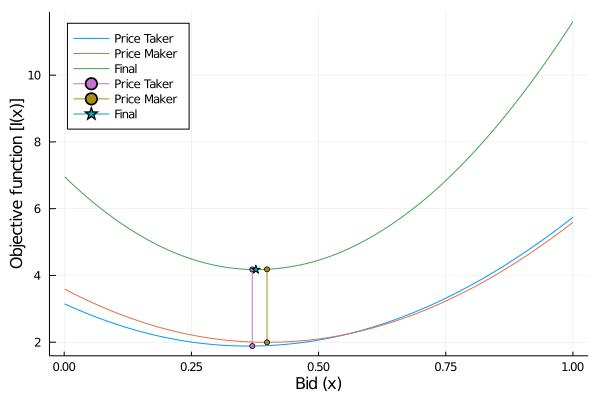

In [21]:
plot(xvals,[objectValues1,objectValues2,objectValues3],xlabel ="Bid (x)", ylabel = "Objective function [I(x)]",legend=:topleft,label = ["Price Taker" "Price Maker" "Final"])
plot!([yc,yc],[obj_pricetaker,objectivefuncs[1]],marker = (:point,3),addmarker = true, label = "Price Taker")
plot!([threeval,threeval],[objval_pricemaker,objectivefuncs[2]],marker = (:point,3),addmarker = true,label = "Price Maker")
plot!([fourval,fourval],[objval4,objval4],marker = (:star,4),addmarker = true, label = "Final")
#savefig("C:\\Users\\matia\\StochasticNewsvendor\\PenaltyDistFinal.png")

It seems that, while the solution are close to the minima, they are still a few decimals off. This might represent a lot of money in a real world setting, and as such we would say that the final solution adds quite a bit of value, at the cost of little complexity. 